In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
                                                       preprocess_input
from tensorflow.keras.preprocessing.image import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import itertools
import glob
import cv2
import os

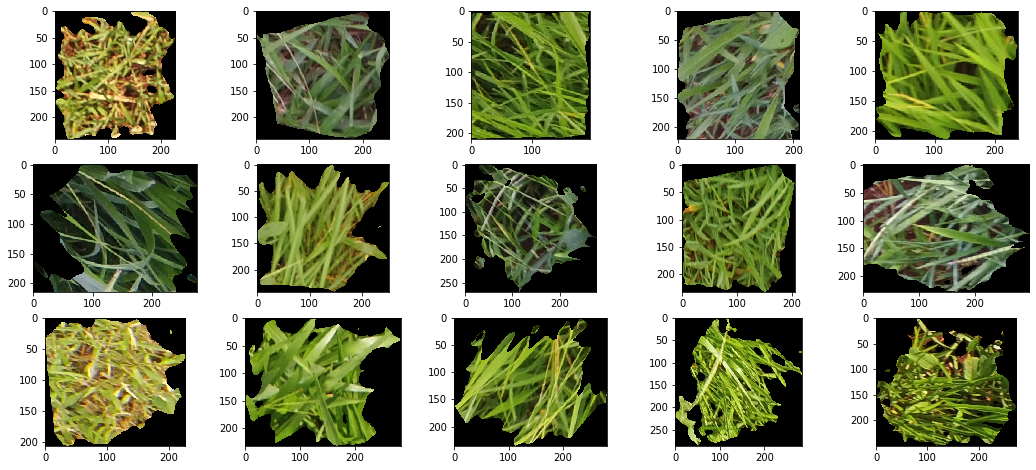

In [2]:
img_paths = glob.glob("dataset/grass/*")

fig = plt.figure(figsize=(18,8))
for idx in range(1,16):
  img = cv2.imread(img_paths[idx])
  plt.subplot(3, 5, idx)
  plt.imshow(img[:,:,::-1])

plt.show()

In [3]:
batch_size = 256

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
      'dataset/',
      target_size=(224, 224),
      batch_size=batch_size,
      subset='training')

validation_generator = train_datagen.flow_from_directory(
      'dataset/',
      target_size=(224, 224),
      batch_size=batch_size,
      subset='validation') 

Found 12270 images belonging to 4 classes.
Found 3066 images belonging to 4 classes.


In [4]:
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(16, 3, padding="same"),
    MaxPool2D(2,2),
    ReLU(),
    Dropout(0.2), 

    Conv2D(32, 3, padding="same"),
    MaxPool2D(2,2),
    ReLU(),
    Dropout(0.3),

    Conv2D(64, 3, padding="same"),
    MaxPool2D(2,2),
    ReLU(),
    Dropout(0.4),

    Conv2D(128, 3, padding="same"),
    MaxPool2D(2,2),
    ReLU(),
    Dropout(0.5),
    
    Conv2D(256, 3, padding="same"),
    MaxPool2D(2,2),
    ReLU(),
    Dropout(0.6),
    
    Flatten(),

    Dense(512, activation="relu"),
    Dropout(0.6),
    Dense(4, activation="softmax")]
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 56, 56, 32)        0

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer=Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=["acc"])

In [7]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // batch_size,
    epochs=10)

Epoch 1/10
47/47 [==============================] - 216s 5s/step - loss: 1.3233 - acc: 0.4221 - val_loss: 1.1793 - val_acc: 0.4819
Epoch 2/10
47/47 [==============================] - 215s 5s/step - loss: 0.8147 - acc: 0.6380 - val_loss: 0.7189 - val_acc: 0.7674
Epoch 3/10
47/47 [==============================] - 214s 5s/step - loss: 0.5383 - acc: 0.7908 - val_loss: 0.5137 - val_acc: 0.7908
Epoch 4/10
47/47 [==============================] - 213s 5s/step - loss: 0.4329 - acc: 0.8374 - val_loss: 0.6687 - val_acc: 0.7262
Epoch 5/10
47/47 [==============================] - 212s 5s/step - loss: 0.3571 - acc: 0.8610 - val_loss: 0.6466 - val_acc: 0.7443
Epoch 6/10
47/47 [==============================] - 212s 5s/step - loss: 0.3264 - acc: 0.8679 - val_loss: 0.5299 - val_acc: 0.7876
Epoch 7/10
47/47 [==============================] - 204s 4s/step - loss: 0.2840 - acc: 0.8881 - val_loss: 0.6240 - val_acc: 0.7901
Epoch 8/10
47/47 [==============================] - 203s 4s/step - loss: 0.2401 - a

In [0]:
class_names = list(validation_generator.class_indices.keys())

In [48]:
class_names

['broadleaf', 'grass', 'soil', 'soybean']

In [110]:
y_test = []
y_pred = []

for i in tqdm(range(validation_generator.samples//batch_size)):
  x, y = validation_generator.next()
  y_test.append(y)
  y_pred.append(model.predict(x))

y_test = np.vstack(y_test)
y_pred = np.vstack(y_pred)


100%|██████████| 11/11 [00:40<00:00,  3.67s/it]


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '{0:.2f}'.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, '{}'.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

In [0]:
cm = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))

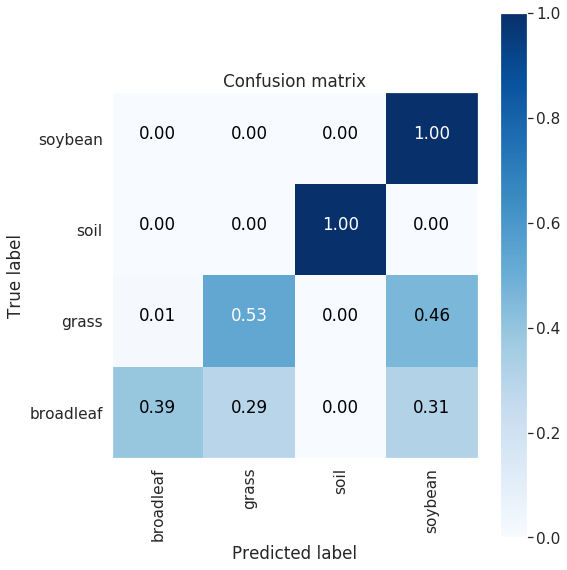

In [115]:
fig = plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.ylim([-0.5, 3.5])
plt.grid(b=None)
plt.show()

In [0]:
model.save("weights/model-84acc.h5")